## Atlas subsampling 

In [259]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [260]:
import os,sys
import scanpy as sc 
import pandas as pd
import numpy as np
import milopy
import scipy
import anndata

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_context('talk')
from matplotlib.pyplot import rc_context

import milopy
import milopy.core as milo

In [699]:
## Some utils

def _plot_nhood_sizes(adata, bins=50, **kwargs):
    plt.hist(np.array(adata.obsm['nhoods'].sum(0)).ravel(), bins=bins, **kwargs);
    plt.xlabel('# cells');plt.ylabel('# nhoods');
    
def get_nhood_adata(adata):
    return(adata.uns['nhood_adata'])

def get_cells_from_nhood(adata, i):
    return((adata.obsm['nhoods'][:,i].toarray() == 1).flatten())

def remove_x_axis(ax):
    ax.xaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_xlabel('');

def remove_y_axis(ax):
    ax.yaxis.set_major_locator(matplotlib.ticker.NullLocator());
    ax.set_ylabel('');

## Load dataset

In [ ]:
data_dir = '/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/'
adata = sc.read_h5ad(data_dir + 'PBMC_merged.normal.subsample500cells.clean_celltypes.h5ad')

## Make sample level anndata

In [265]:
sc.pp.neighbors(adata, use_rep='X_scVI', n_neighbors=100)

In [266]:
## Make nhoods
milo.make_nhoods(adata, prop=0.01)
milo.count_nhoods(adata, sample_col='donor_id')
milopy.utils.add_covariate_to_nhoods_var(adata, ['sex', 'dataset_id', 'ethnicity', 'assay'])
sample_adata = adata.uns['nhood_adata'].T.copy()
sample_adata.layers['counts'] = sample_adata.X.copy()

## Normalize counts x donor
sc.pp.normalize_total(sample_adata, target_sum=10000)
sc.pp.log1p(sample_adata)

## Dim reduction
sc.pp.pca(sample_adata)

## Compute similarity between donors
n_pcs = 30
X_pca = sample_adata.obsm['X_pca']
sample_adata.obsp['distance_full'] = scipy.spatial.distance.cdist(X_pca[:,0:n_pcs], X_pca[:,0:n_pcs])

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [267]:
sample_adata.write_h5ad(data_dir + 'PBMC_merged.normal.subsample500cells.clean_celltypes.donor_adata.h5ad')

In [505]:
sample_adata = sc.read_h5ad(data_dir + 'PBMC_merged.normal.subsample500cells.clean_celltypes.donor_adata.h5ad')

### Compare controls 

In [506]:
## Define query donors
np.random.seed(41)
query_dataset = '10_1038_s41591_021_01329_2'
samples_design = np.random.choice((0, 1), sum(sample_adata.obs['dataset_id'] == query_dataset))
query_samples = sample_adata.obs_names[sample_adata.obs['dataset_id'] == query_dataset][samples_design == 1]


In [507]:
## Find set of closest samples to subset atlas
def find_ctrl_samples(
    sample_adata, 
    ctrl_samples_all,
    query_samples, 
    method = 'closest', ## one of closest, farthest, random
    n_ctrl: int = 15,
    random_seed = 42,
    n_pcs = 30
    ):
    '''
    Params:
    ------
    - sample_adata: sample-level anndata object
    - query_samples: list or collection of samples from query dataset
    - n_ctrl: number of control samples to pick
    '''
    
    # Get distances to query samples
    query_distances = scipy.spatial.distance.cdist(sample_adata[query_samples,:].obsm['X_pca'][:,0:n_pcs], sample_adata[ctrl_samples_all,:].obsm['X_pca'][:,0:n_pcs])
    
    # Get n_ctrl closest samples
    if method == 'closest':
        n_closest = 0
        k = 1
        ctrl_samples = np.array([])
        while n_closest < n_ctrl:
            closest_samples_k = np.argsort(query_distances, axis=1)[:,0:k]
            closest_samples = np.setdiff1d(np.unique(closest_samples_k), ctrl_samples)
            closest_dist = query_distances[:,closest_samples].min(axis=0).argsort()
            ctrl_samples = np.hstack([ctrl_samples, closest_samples[closest_dist][0:(n_ctrl - n_closest)]])
            n_closest = len(ctrl_samples)
            k +=1
        ctrl_samples = ctrl_samples_all[ctrl_samples.astype('int')]

    if method == 'farthest':
        n_closest = 0
        k = 1
        ctrl_samples = np.array([])
        while n_closest < n_ctrl:
            closest_samples_k = np.argsort(query_distances, axis=1)[:,-k:]
            closest_samples = np.setdiff1d(np.unique(closest_samples_k), ctrl_samples)
            closest_dist = query_distances[:,closest_samples].min(axis=0).argsort()
            ctrl_samples = np.hstack([ctrl_samples, closest_samples[closest_dist][0:(n_ctrl - n_closest)]])
            n_closest = len(ctrl_samples)
            k +=1
        ctrl_samples = ctrl_samples_all[ctrl_samples.astype('int')]

    if method == 'random':
        np.random.seed(random_seed)
        ctrl_samples = np.random.choice(ctrl_samples_all, n_ctrl, replace=False)

    return(ctrl_samples)
# ## Get ctrl samples closest to avg of query samples
# closest_samples = ctrl_samples[np.argsort(query_distances.mean(axis=0))[0:n_ctrl]]

In [508]:
## Matched control samples
matched_ctrl = sample_adata.obs_names[(sample_adata.obs['dataset_id'] == query_dataset) & (~sample_adata.obs_names.isin(query_samples))]
sample_adata.obs[f'matched_ctrl'] = sample_adata.obs_names.isin(matched_ctrl).astype('int')

ctrl_samples_all = sample_adata.obs_names[sample_adata.obs['dataset_id'] != query_dataset]
n_ctrl = len(matched_ctrl)

## Closest control samples
closest_ctrl = find_ctrl_samples(sample_adata, ctrl_samples_all, query_samples, method='closest', n_ctrl=n_ctrl)
sample_adata.obs[f'close_ctrl'] = sample_adata.obs_names.isin(closest_ctrl).astype('int')

## Farthest control samples
far_ctrl = find_ctrl_samples(sample_adata, ctrl_samples_all, query_samples, method='farthest', n_ctrl=n_ctrl)
sample_adata.obs[f'far_ctrl'] = sample_adata.obs_names.isin(far_ctrl).astype('int')

## Random control samples (x 3)
for i in [1,2,3]:
    random_ctrl = find_ctrl_samples(sample_adata, ctrl_samples_all, query_samples, n_ctrl=n_ctrl, method = 'random', random_seed = 42+i)
    sample_adata.obs[f'random{i}_ctrl'] = sample_adata.obs_names.isin(random_ctrl).astype('int')

In [583]:
ctrl_comparison_design = sample_adata.obs.loc[:,sample_adata.obs.columns.str.endswith('_ctrl')]
ctrl_comparison_design['is_test'] = sample_adata.obs_names.isin(query_samples).astype('int')

,matched_ctrl,close_ctrl,far_ctrl,random1_ctrl,random2_ctrl,random3_ctrl
02752262-cbb5-4389-992d-6c76b7244bc3,0,0,0,0,0,0
034080ee-d3dc-41c5-b323-5ed49aa24496,0,0,0,0,0,0
03b233c8-d3e2-4438-8b04-0b6621fb5635,0,0,0,0,0,0
048b4a65-6016-4ae6-80ec-8b2e5a7b9745,0,0,0,0,0,0
098af13e-2d39-4ac7-ac3b-c6b45f5b30b7,0,0,0,0,0,0
...,...,...,...,...,...,...
f8453961-779f-4dcc-97c6-c187b5d91f7c,0,0,0,0,0,0
fedca3f8-0480-43d4-b3dd-c219bad56084,0,0,0,0,0,0
newcastle65,1,0,0,0,0,0
newcastle74,1,0,0,0,0,0


In [ ]:
ctrl_comparison_design.to_csv(data_dir + 'ctrl_comparison_design.csv')

### Run ctrl comparison

In [513]:
conda activate scvi-env
cd /nfs/team205/ed6/bin/diff2atlas/scripts

outdir=/lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/

# p=naive_B_cell
for p in $(cat /lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/PBMC_merged.normal.subsample500cells.clean_celltypes.txt); do
    for c in random1 random2 random3 close far; do
        echo "python run_ctrl_comparison.py PBMC_merged.normal.subsample500cells.clean_celltypes.h5ad ${c} ${p} --outpath ${outdir}" | \
            bsub -G teichlab -o logfile-scvi-%J.out -e logfile-scvi-%J.err -q gpu-normal -M25000 -R "select[mem>25000] rusage[mem=25000]" -gpu "mode=shared:j_exclusive=no:gmem=6000:num=1" 
    done
done

for p in $(cat /lustre/scratch117/cellgen/team205/ed6/PBMC_CZI_integration_filtered/PBMC_merged.normal.subsample500cells.clean_celltypes.txt); do
    for c in matched; do
        echo "python run_ctrl_comparison.py PBMC_merged.normal.subsample500cells.clean_celltypes.h5ad ${c} ${p} --outpath ${outdir}" | \
            bsub -G teichlab -o logfile-scvi-%J.out -e logfile-scvi-%J.err -q gpu-normal -M25000 -R "select[mem>25000] rusage[mem=25000]" -gpu "mode=shared:j_exclusive=no:gmem=6000:num=1" 
    done
done

View of AnnData object with n_obs × n_vars = 16 × 5916
    obs: 'ethnicity', 'sex', 'dataset_id', 'assay', 'donor_id', 'matched_ctrl', 'close_ctrl', 'far_ctrl', 'random1_ctrl', 'random2_ctrl', 'random3_ctrl'
    var: 'index_cell', 'kth_distance'
    uns: 'log1p', 'pca', 'sample_col'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distance_full'

### Load results

In [692]:
def _add_perturb_pop_info(pac_design_adata, perturb_pop,
                            min_perturb_cells = 10, population_obs = 'cell_type'):
    pac_design_adata.obs['is_perturb_pop'] = pac_design_adata.obs[population_obs] == perturb_pop
    perturb_nhoods = pac_design_adata.obsm['nhoods'][pac_design_adata.obs['is_perturb_pop']].toarray().sum(0) > min_perturb_cells
    pac_design_adata.uns['nhood_adata'].obs['is_perturb_nhood'] = perturb_nhoods
    pac_design_adata.uns['nhood_adata'].obs['n_perturb_cells'] = pac_design_adata.obsm['nhoods'][pac_design_adata.obs['is_perturb_pop']].toarray().sum(0)
    pac_design_adata.uns['nhood_adata'].obs['n_cells'] = np.array(pac_design_adata.obsm['nhoods'].sum(0)).flatten()
    pac_design_adata.uns['nhood_adata'].obs['frac_perturb_cells'] = pac_design_adata.uns['nhood_adata'].obs['n_perturb_cells']/pac_design_adata.uns['nhood_adata'].obs['n_cells']

def run_milo(pac_design_adata,
             query_group,
             reference_group,
             sample_col='sample_id',
             annotation_col='cell_type'
             ):
    try:
        milopy.core.make_nhoods(pac_design_adata, prop=0.1)
    except:
        sc.pp.neighbors(pac_design_adata, use_rep='X_scVI')
        milopy.core.make_nhoods(pac_design_adata, prop=0.1)
    milopy.core.count_nhoods(pac_design_adata, sample_col=sample_col)
    milopy.utils.annotate_nhoods(
        pac_design_adata[pac_design_adata.obs['dataset_group'] == reference_group], annotation_col)
    pac_design_adata.obs['is_query'] = pac_design_adata.obs['dataset_group'] == query_group
    milopy.core.DA_nhoods(pac_design_adata, design='~ is_query')
    try:
        milopy.utils.build_nhood_graph(pac_design_adata)
    except:
        sc.pl.umap(sdata)
        milopy.utils.build_nhood_graph(pac_design_adata)

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


In [714]:
# def load_ctrl_comparison():
population_obs = 'cell_type' 
dirs = [x for x in os.listdir(data_dir) if x.startswith('ctrl_comparison_PBMC_500cells') and ~x.endswith('.csv')]

nhood_obs_all = pd.DataFrame()
for d in dirs:
    try:
        sdata = sc.read(data_dir + d + "/pac_design.h5ad", backed=True)
    except:
        pass
    perturb_pop = d.split(population_obs)[1].split('_ctrl')[0]
    ctrl_class = d.split('_ctrl_')[1]
    run_milo(sdata, 'query', 'ctrl', sample_col='donor_id', annotation_col='cell_type')
    _add_perturb_pop_info(sdata, perturb_pop)
    ## Store nhood info
    nhood_obs = get_nhood_adata(sdata).obs.copy()
    nhood_obs['ctrl_class'] = ctrl_class
    nhood_obs['perturb_pop'] = perturb_pop
    nhood_obs_all = pd.concat([nhood_obs_all, nhood_obs])

/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/rpy2/robjects/vectors.py:980: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/milopy/core.py:272: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/jovyan/my-conda-envs/emma_env/lib/python3.7

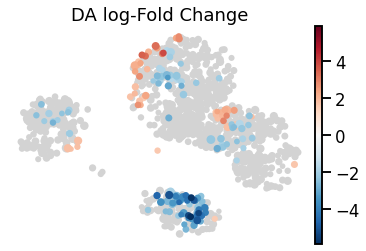

In [ ]:
nhood_obs_all.to_csv(data_dir + 'ctrl_comparison_nhood_obs_all.csv')
